In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised import SupervisedDataLoader
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
np.set_printoptions(precision=4)
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()

16-Jun-19 12:33:07 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
16-Jun-19 12:33:07 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [4]:
load_app_config()
DATA_DIRECTORY='HRAnalytics'
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "is_promoted"
input_path = get_datafolder_path()

16-Jun-19 12:33:09 - INFO - Adding D:\DataSource to system path
16-Jun-19 12:33:09 - INFO - Adding D:\MachineLearning to system path


In [5]:
filepath  = pathlib.Path(input_path).joinpath(DATA_DIRECTORY)
train_filepath = filepath.joinpath(TRAIN_FILE)
test_filepath = filepath.joinpath(TEST_FILE)

In [6]:
supervisedloader = SupervisedDataLoader(train_file=train_filepath,test_file=test_filepath,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
train_y = train_dataset[RESPONSE]

16-Jun-19 12:33:10 - INFO - Loading train_file :D:\DataSource\HRAnalytics\train.csv
16-Jun-19 12:33:10 - INFO - Loading test_file :D:\DataSource\HRAnalytics\test.csv


In [7]:
train_dataset.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0


In [8]:
def extended_describe(dataframe):
    extended_describe_df= dataframe.describe(include='all').T 
    extended_describe_df['null_count']= dataframe.shape[0]- extended_describe_df['count']
    return extended_describe_df

In [9]:
extended_describe(train_dataset)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count
employee_id,"54,808.0000",NaN,NaN,NaN,"39,195.8306","22,586.5814",1.0000,"19,669.7500","39,225.5000","58,730.5000","78,298.0000",0.0000
department,54808,9,Sales & Marketing,16840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
region,54808,34,region_2,12343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
education,52399,3,Bachelor's,36669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2409
gender,54808,2,m,38496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
recruitment_channel,54808,3,other,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
no_of_trainings,"54,808.0000",NaN,NaN,NaN,1.2530,0.6093,1.0000,1.0000,1.0000,1.0000,10.0000,0.0000
age,"54,808.0000",NaN,NaN,NaN,34.8039,7.6602,20.0000,29.0000,33.0000,39.0000,60.0000,0.0000
previous_year_rating,"50,684.0000",NaN,NaN,NaN,3.3293,1.2600,1.0000,3.0000,3.0000,4.0000,5.0000,"4,124.0000"
length_of_service,"54,808.0000",NaN,NaN,NaN,5.8655,4.2651,1.0000,3.0000,5.0000,7.0000,37.0000,0.0000


In [10]:
extended_describe(test_dataset)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count
employee_id,"23,490.0000",NaN,NaN,NaN,"39,041.3991","22,640.8092",3.0000,"19,370.2500","38,963.5000","58,690.0000","78,295.0000",0.0000
department,23490,9,Sales & Marketing,7315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
region,23490,34,region_2,5299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
education,22456,3,Bachelor's,15578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1034
gender,23490,2,m,16596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
recruitment_channel,23490,3,other,13078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
no_of_trainings,"23,490.0000",NaN,NaN,NaN,1.2542,0.6009,1.0000,1.0000,1.0000,1.0000,9.0000,0.0000
age,"23,490.0000",NaN,NaN,NaN,34.7829,7.6795,20.0000,29.0000,33.0000,39.0000,60.0000,0.0000
previous_year_rating,"21,678.0000",NaN,NaN,NaN,3.3391,1.2633,1.0000,3.0000,3.0000,4.0000,5.0000,"1,812.0000"
length_of_service,"23,490.0000",NaN,NaN,NaN,5.8104,4.2079,1.0000,3.0000,5.0000,7.0000,34.0000,0.0000


In [11]:
train_dataset[RESPONSE].value_counts(normalize=True)

0   0.9148
1   0.0852
Name: is_promoted, dtype: float64

16-Jun-19 12:33:12 - DEBUG - update_title_pos
16-Jun-19 12:33:13 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('C:\\WINDOWS\\Fonts\\arial.ttf') with score of 0.050000.
16-Jun-19 12:33:13 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('C:\\WINDOWS\\Fonts\\arial.ttf') with score of 0.050000.
16-Jun-19 12:33:13 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.2 to Arial ('C:\\WINDOWS\\Fonts\\arial.ttf') with score of 0.050000.
16-Jun-19 12:33:13 - DEBUG - update_title_pos
16-Jun-19 12:33:13 - DEBUG - update_title_pos
16-Jun-19 12:33:13 - DEBUG - update_title_pos
16-Jun-19 12:33:13 - DEBUG - update_title_pos


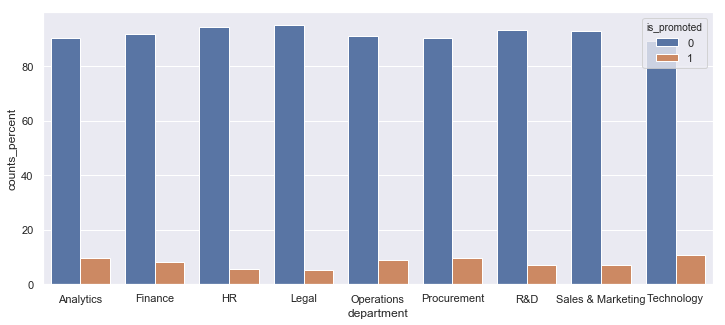

In [12]:
train_group_by_dept = train_dataset.groupby(['department'])[RESPONSE].value_counts(normalize=True).reset_index(name='counts_percent') 
train_group_by_dept['counts_percent'] =train_group_by_dept['counts_percent'] *100
fig = plt.figure(figsize=(12,5))
g = sns.barplot(x="department", y="counts_percent", hue="is_promoted", data=train_group_by_dept )

In [24]:
train_group_by_dept[train_group_by_dept['is_promoted']==1].sort_values(by=['counts_percent'],ascending=False)

,department,is_promoted,counts_percent
17,Technology,1,10.7593
11,Procurement,1,9.6386
1,Analytics,1,9.5665
9,Operations,1,9.0148
3,Finance,1,8.1230
15,Sales & Marketing,1,7.2031
13,R&D,1,6.9069
5,HR,1,5.6245
7,Legal,1,5.1011


16-Jun-19 12:34:55 - DEBUG - update_title_pos
16-Jun-19 12:34:56 - DEBUG - update_title_pos
16-Jun-19 12:34:56 - DEBUG - update_title_pos
16-Jun-19 12:34:56 - DEBUG - update_title_pos
16-Jun-19 12:34:56 - DEBUG - update_title_pos


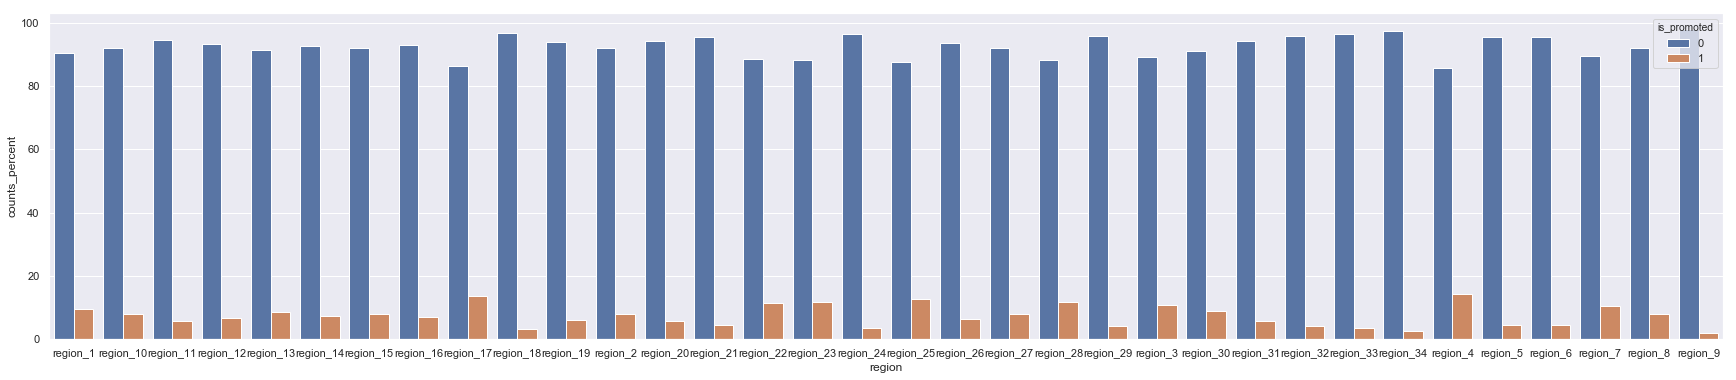

In [16]:
train_group_by_region = train_dataset.groupby(['region'])[RESPONSE].value_counts(normalize=True).reset_index(name='counts_percent') 
train_group_by_region['counts_percent'] =train_group_by_region['counts_percent'] *100
fig = plt.figure(figsize=(30,6))
g = sns.barplot(x="region", y="counts_percent", hue="is_promoted", data=train_group_by_region )

In [25]:
promotion_priority_by_region = train_group_by_region[train_group_by_region['is_promoted']==1].sort_values(by=['counts_percent'],ascending=False)


,region,is_promoted,counts_percent
57,region_4,1,14.4451
17,region_17,1,13.6935
35,region_25,1,12.5763
41,region_28,1,11.6844
31,region_23,1,11.6596
29,region_22,1,11.4188
45,region_3,1,10.6936
63,region_7,1,10.6546
1,region_1,1,9.5082
47,region_30,1,8.9802


In [31]:
toplevel_region = promotion_priority_by_region[promotion_priority_by_region['counts_percent']>=10]['region'].values.tolist()
mid_level_region = promotion_priority_by_region[(promotion_priority_by_region['counts_percent']<10)&
                                             (promotion_priority_by_region['counts_percent']>=5)
                                            ]['region'].values.tolist()
low_level_region=promotion_priority_by_region[promotion_priority_by_region['counts_percent']<5]['region'].values.tolist()


In [42]:
train_group_by_education = train_dataset.groupby(['education','department'])[RESPONSE].value_counts(normalize=True).reset_index(name='counts_percent') 
train_group_by_education['counts_percent'] =train_group_by_education['counts_percent'] *100
train_group_by_education_sorted=train_group_by_education[train_group_by_education['is_promoted']==1].sort_values(by=['counts_percent'],ascending=False)

In [43]:
train_group_by_education_sorted['Rank']=train_group_by_education_sorted['counts_percent'].rank(method ='average') 
train_group_by_education_sorted

,education,department,is_promoted,counts_percent,Rank
29,Below Secondary,Technology,1,15.4229,24.0000
41,Master's & above,Procurement,1,11.5173,23.0000
39,Master's & above,Operations,1,11.3112,22.0000
31,Master's & above,Analytics,1,10.8968,21.0000
17,Bachelor's,Technology,1,10.7066,20.0000
47,Master's & above,Technology,1,10.5647,19.0000
1,Bachelor's,Analytics,1,9.3766,18.0000
11,Bachelor's,Procurement,1,8.8322,17.0000
33,Master's & above,Finance,1,8.6172,16.0000
9,Bachelor's,Operations,1,8.3151,15.0000


####  8.5 percent is the  organization's promotion percent  